In [54]:
"Import the required packages"
from cmath import sqrt
import numpy as np
from scipy.linalg import lu, svd,schur,qr
import sklearn.datasets as data
import time
import matplotlib.pylab as plt
import os

In [2]:
def spd_matrix(n, sparsity = None, *args):
    """ Creates sparse or dense Semi Positive Definite matrix
    
        args:
            dim : int, default=1
                The size of the random matrix to generate.
    
            alpha : float, default=0.95
                The probability that a coefficient is zero. Larger values enforce more sparsity.
                The value should be in the range 0 and 1.
    
            norm_diag :bool, default=False
                    Whether to normalize the output matrix to make the leading diagonal elements all 1

            smallest_coef :float, default=0.1
                        The value of the smallest coefficient between 0 and 1.

            largest_coef :float, default=0.9
                        The value of the largest coefficient between 0 and 1.

            random_state :int, RandomState instance or None, default=None
                        Determines random number generation for dataset creation. 
                        Pass an int for reproducible output across multiple function calls.
            
        returns:
            array: semi positive definite n x n dimansional matrix and sparsity rate the matrix
        
        Possible Error : 
            When the dimansion of the matrix increase; the alpha should be increased as well however,
            above 600 x 600 matrix dimansion (emprically since sklearn uses randomization) yields to generating non-spd matrix.
        
    """
    
    if sparsity :
        A = data.make_sparse_spd_matrix(dim = n, alpha = sparsity, norm_diag = False, 
                                    smallest_coef = 0.1, largest_coef = 0.9, random_state = None)
        
    else:
        A = data.make_spd_matrix(n, *args)
          
    return A

In [ ]:
def diagonally_dominant_matrix():
    """ Created diagonally dominant square matrix
    
        Since Levy–Desplanques theorem proved that a strictly diagonally dominant matrix is non-singular"""

In [3]:
""" create a sparse or dense spd matrix """
A = spd_matrix(4, .5)
print(A)

[[ 1.01835549 -0.89382787 -0.13548244  0.        ]
 [-0.89382787  2.38592145  0.25555455 -0.76615481]
 [-0.13548244  0.25555455  1.11125875 -0.33355472]
 [ 0.         -0.76615481 -0.33355472  1.        ]]


In [4]:
def symmetry_check(a, rtol = 1e-05, atol = 1e-08):
    " Check if the system is symmetric means A = Transpose of A "
    
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [5]:
symmetry_check(A)

True

In [6]:
def pos_semidef_check (x):
    " Check if all eigen values are nonnegative "
    
    w,v = np.linalg.eig(x)
    
    #print("Eigenvalues :",w)
    #print("Eigenvectors :", v)
    return np.all(w >= 0)

In [7]:
pos_semidef_check(A)

True

In [23]:
def custom_cholesky (A):
    """ Cholesky algorithm for decomposition of a SPD matrix, returns lower triangular matrix """
    
    check = pos_semidef_check(A) and symmetry_check(A)
    
    if check == True:
        
        L = np.zeros_like(A, dtype = float) # without dtype = float it introduces rounding error
        n = len(A)

    # Perform the Cholesky decomposition
        for i in range(n):
            for k in range(i+1):
                tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
                
                if (i == k): # Diagonal elements
                # l_{kk} = \sqrt{ a_{kk} - \sum^{k-1}_{j=1} l^2_{kj}}
                    
                    L[i][k] = abs(sqrt(A[i][i] - tmp_sum))
                else:
                # l_{ik} = \frac{1}{l_{kk}} \left( a_{ik} - \sum^{k-1}_{j=1} l_{ij} l_{kj} \right)
                    L[i][k] = abs((A[i][k] - tmp_sum) / L[k][k])
        return L
        
    else:
        return f" Check fails "
    

In [24]:
custom_cholesky(A)

array([[1.00913601, 0.        , 0.        , 0.        ],
       [0.88573578, 1.26546181, 0.        , 0.        ],
       [0.13425587, 0.10797586, 1.03998814, 0.        ],
       [0.        , 0.60543495, 0.3835881 , 0.69735836]])

In [25]:
def numpy_cholesky(A) :
    """ Cholesky decomposition method from numpy """
    
    return np.linalg.cholesky(A)

In [63]:
def scipy_lu(A) :
    """ LU decomposition method from numpy """
    
    return lu(A)

In [45]:
def numpy_spectral(A) :
    """ Eigen decomposition method from numpy """
    
    return np.linalg.eig(A)

In [52]:
def scipy_svd(A) :
    """ SVD decomposition method from numpy """
    
    return svd(A)

In [58]:
def scipy_schur(A) :
    """ Schur decomposition method from numpy """
    
    return schur(A)

In [59]:
def scipy_qr(A) :
    """ QR decomposition method from numpy """
    
    return qr(A)

In [62]:
scipy_qr(A)

(array([[-0.74783486, -0.55796252,  0.01171848,  0.35956019],
        [ 0.65638732, -0.63243599,  0.16089455,  0.37854107],
        [ 0.09949226, -0.02151781, -0.97339887,  0.20526302],
        [-0.        ,  0.53687944,  0.16269681,  0.82782258]]),
 array([[-1.36173847,  2.25994993,  0.3796229 , -0.53608042],
        [ 0.        , -1.42705188, -0.28901829,  1.02860068],
        [ 0.        ,  0.        , -1.09643662,  0.36410846],
        [ 0.        ,  0.        ,  0.        ,  0.46933506]]))

In [69]:
class TEST():
    def __init__(self, mtrx, fact, typ, dim, test_run, *args):
        """ Class to test how different algorithms perform factorization process
        
             By the help of passed different combination of variables and methods, this claass test
             the performance of algorithms, saves the results in a npy file and read it back
             
            Args:
                mtrx: str, matrix type to use e.g "spd" creates Semi Positive Definite, 
                    since the project in under development we will add some other specific matrices.
                    
                fact: str, factorization algorithm to use e.g. "cholesky" 
                
                typ: str, specific factorization algorhm to use e.g. "numpy" returns the factorization 
                    method from that library
                     
                dim: int, dimantionality of the square matrix 
                    Possible change : we may change this argument as tuple to create 
                    non-square matrices for different applications
                     
                est_run: int, for every dimansion step we run the factorization algorithms this varible times
                     
            Returns:
                results: array, averaged test results for every dimantion of the matrix
            
        """
        
        self.matrix = { "spd" : spd_matrix }
        self.factorization = { "cholesky" : {"custom" : custom_cholesky, "numpy" : numpy_cholesky},
                               "lu" : {"scipy" : scipy_lu},
                               "spectral" : {"numpy" : numpy_spectral},
                               "svd" : {"scipy" : scipy_svd},
                               "schur" : {"scipy" : scipy_schur},
                               "qr" : {"scipy" : scipy_qr},
                               }
        
        self.dim = dim
        self.test_run = test_run
        self.typ = typ
        self.fact = fact
        self.A = self.matrix[mtrx](self.dim, *args)
        self.rate = TEST.get_sparsity(self, self.A)

        
    def stochastic_test(self,):
        results = []
        t = np.array(0, dtype=float)
        
        for j in range(self.dim):
            for i in range(self.test_run):
                t_0 = time.time()
                L = self.factorization[self.fact][self.typ](self.A)
                t_1 = time.time() - t_0
                t = np.append(t, t_1)                
                T = np.sum(t / self.test_run, dtype=float)
                
            results.append([j+1,T])
            
            TEST.save_file(self, results, self.rate)
            
        plt.title("Sparsity Scheme of Main Matrix")
        plt.spy(self.mat)
        
        
        return results
        
        #print(t,L)
        #for i in range(self.test_run):
        
    def get_sparsity(self, m):
        self.mat = m
        n = self.dim
        sparsity_rate = self.mat[np.where(self.mat == 0)].size / (n*n)
        
        return sparsity_rate
            
    def save_file(self, results, rate):
        self.current_dir = os.getcwd()
        self.new_dir = self.current_dir+"\\results_"+self.fact
        self.results = results
        self.rate = str(rate)
        
        try : 
            os.mkdir(self.new_dir)
        except OSError as error:
            pass

        outfile = self.typ+"_"+self.fact+"_"+str(self.dim)+"dim"+"_"+str(self.test_run)+"run"+"_"+self.rate+"sparsity"
        out_path = self.new_dir+"\\"+outfile
                
        return np.save(out_path, self.results, allow_pickle=True, fix_imports=True)
                          

[[1, 0.0057849884033203125], [2, 0.009772491455078124], [3, 0.013562345504760742], [4, 0.01735382080078125], [5, 0.021246480941772457], [6, 0.025036191940307616], [7, 0.028729200363159176], [8, 0.03251934051513672], [9, 0.03630914688110352], [10, 0.040099143981933594], [11, 0.043734836578369136], [12, 0.047630357742309566], [13, 0.051220703125], [14, 0.05501046180725098], [15, 0.058906221389770516], [16, 0.06270422935485839], [17, 0.06669378280639648], [18, 0.07068309783935547], [19, 0.07469477653503419], [20, 0.07868418693542481], [21, 0.08267340660095214], [22, 0.08666276931762693], [23, 0.09038629531860352], [24, 0.09437556266784668], [25, 0.09806966781616212], [26, 0.10205912590026855], [27, 0.1058495044708252], [28, 0.10964155197143555], [29, 0.1135434150695801], [30, 0.11733312606811525], [31, 0.12112302780151368], [32, 0.12491288185119628], [33, 0.12882323265075685], [34, 0.1323112964630127], [35, 0.13610124588012695], [36, 0.13989105224609374], [37, 0.14368114471435545], [38, 0

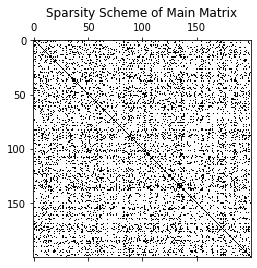

In [70]:
t = TEST("spd","qr", "scipy", 200, 5, .95)
print(t.stochastic_test())